In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from scipy.stats import normaltest
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

import missingno as msno

import os
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import random
seed_value = 99
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

sns.set_theme(style="darkgrid", context= "paper")

In [51]:
HMDA_clean_final = pd.read_pickle("C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/interim/HMDA_clean_final.pkl")

In [52]:
HMDA_clean_final['loan_granted'] = (HMDA_clean_final['loan_granted'] == 'Granted').astype(int)

HMDA_encoded = pd.get_dummies(HMDA_clean_final, columns=['applicant_sex', 'applicant_race-1', 'loan_type', 'debt_to_income_ratio', 'lien_status'], drop_first=True)

X = HMDA_encoded.drop(columns=['loan_granted'])
y = HMDA_encoded['loan_granted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [53]:
print(X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(545238, 19) (136310, 19) (170388, 19)
(545238,) (136310,) (170388,)


XXX

In [54]:
BLD_train_df = pd.get_dummies(HMDA_clean_final.loc[X_train.index], columns=['applicant_sex', 'applicant_race-1', 'loan_type', 'debt_to_income_ratio', 'lien_status'], drop_first=False)

In [55]:
for col in BLD_train_df.columns:
    if BLD_train_df[col].dtype == 'bool':
        BLD_train_df[col] = BLD_train_df[col].astype(int)

In [56]:
BLD_train_df.head()

,county_code,interest_rate,loan_to_value_ratio,loan_granted,applicant_sex_Male,applicant_sex_Female,applicant_race-1_Black or African American,applicant_race-1_White,loan_type_Conventional,loan_type_FHA,...,debt_to_income_ratio_36,debt_to_income_ratio_37%-41%,debt_to_income_ratio_41%-45%,debt_to_income_ratio_46%-49%,debt_to_income_ratio_50%-60%,debt_to_income_ratio_<20%,debt_to_income_ratio_>60%,debt_to_income_ratio_missing,lien_status_First lien,lien_status_Subordinate lien
115410,30013,4.990000,100.000000,1,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
630420,48119,4.560661,71.241202,0,1,0,1,0,1,0,...,0,0,0,1,0,0,0,0,1,0
612581,48085,4.560661,71.241202,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,1
670964,48085,4.560661,71.241202,1,1,0,0,1,1,0,...,0,0,0,0,0,1,0,0,1,0
179727,30111,7.000000,52.055000,1,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1


In [57]:
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.datasets import BinaryLabelDataset

In [58]:
privileged_groups = [{'applicant_race-1_White': 1}]
unprivileged_groups = [{'applicant_race-1_White': 0}]

privileged_groups_2 = [{'applicant_sex_Male': 1}]
unprivileged_groups_2 = [{'applicant_sex_Male': 0}]

train_bld = BinaryLabelDataset(df=BLD_train_df, label_names=['loan_granted'], protected_attribute_names=['applicant_race-1_White', 'applicant_race-1_Black or African American'], favorable_label=1.0, unfavorable_label=0.0)
train_bld_2 = BinaryLabelDataset(df=BLD_train_df, label_names=['loan_granted'], protected_attribute_names=['applicant_sex_Male', 'applicant_sex_Female'], favorable_label=1.0, unfavorable_label=0.0)


metric_orig_train = BinaryLabelDatasetMetric(train_bld, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

metric_orig_train_2 = BinaryLabelDatasetMetric(train_bld_2, 
                                             unprivileged_groups=unprivileged_groups_2,
                                             privileged_groups=privileged_groups_2)

print("Difference in mean outcomes between unprivileged and privileged groups - Race = %f" % metric_orig_train.mean_difference())
print("Difference in mean outcomes between unprivileged and privileged groups - Sex = %f" % metric_orig_train_2.mean_difference())

Difference in mean outcomes between unprivileged and privileged groups - Race = -0.148808
Difference in mean outcomes between unprivileged and privileged groups - Sex = -0.036731


In [59]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_train = RW.fit_transform(train_bld)

In [60]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Difference in mean outcomes between unprivileged and privileged groups - Race = %f" % metric_transf_train.mean_difference())

Difference in mean outcomes between unprivileged and privileged groups - Race = -0.000000


In [61]:
print(pd.DataFrame(train_bld.convert_to_dataframe()[0][["county_code", "interest_rate", "loan_to_value_ratio"]]).head(), "\n", "\n", X_train[["county_code", "interest_rate", "loan_to_value_ratio"]].head())

        county_code  interest_rate  loan_to_value_ratio
115410      30013.0       4.990000           100.000000
630420      48119.0       4.560661            71.241202
612581      48085.0       4.560661            71.241202
670964      48085.0       4.560661            71.241202
179727      30111.0       7.000000            52.055000 
 
        county_code  interest_rate  loan_to_value_ratio
115410       30013       4.990000           100.000000
630420       48119       4.560661            71.241202
612581       48085       4.560661            71.241202
670964       48085       4.560661            71.241202
179727       30111       7.000000            52.055000


In [62]:
Train_fair = pd.DataFrame(train_bld.convert_to_dataframe()[0])

In [105]:
Train_fair.describe()

,county_code,interest_rate,loan_to_value_ratio,applicant_sex_Male,applicant_sex_Female,applicant_race-1_Black or African American,applicant_race-1_White,loan_type_Conventional,loan_type_FHA,loan_type_VA,...,debt_to_income_ratio_37%-41%,debt_to_income_ratio_41%-45%,debt_to_income_ratio_46%-49%,debt_to_income_ratio_50%-60%,debt_to_income_ratio_<20%,debt_to_income_ratio_>60%,debt_to_income_ratio_missing,lien_status_First lien,lien_status_Subordinate lien,loan_granted
count,545238.000000,545238.000000,545238.000000,545238.000000,545238.000000,545238.000000,545238.000000,545238.000000,545238.000000,545238.000000,...,545238.000000,545238.000000,545238.000000,545238.000000,545238.000000,545238.000000,545238.000000,545238.000000,545238.000000,545238.000000
mean,43877.231382,4.560750,71.250975,0.652632,0.347368,0.154382,0.845618,0.815697,0.105189,0.070549,...,0.122682,0.108054,0.084345,0.063625,0.047093,0.040947,0.261301,0.858665,0.141335,0.579010
std,9573.854372,1.207122,18.529292,0.476134,0.476134,0.361315,0.361315,0.387731,0.306797,0.256070,...,0.328072,0.310449,0.277905,0.244085,0.211838,0.198168,0.439344,0.348367,0.348367,0.493718
min,22001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48029.000000,4.560661,71.241202,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,48201.000000,4.560661,71.241202,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,48439.000000,4.740000,78.247750,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
max,49057.000000,18.990000,250.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [108]:
X_train.astype(float).describe()

,county_code,interest_rate,loan_to_value_ratio,applicant_sex_Female,applicant_race-1_White,loan_type_FHA,loan_type_VA,loan_type_FSA/RHS,debt_to_income_ratio_20%-<30%,debt_to_income_ratio_30%-<36%,debt_to_income_ratio_36,debt_to_income_ratio_37%-41%,debt_to_income_ratio_41%-45%,debt_to_income_ratio_46%-49%,debt_to_income_ratio_50%-60%,debt_to_income_ratio_<20%,debt_to_income_ratio_>60%,debt_to_income_ratio_missing,lien_status_Subordinate lien
count,545238.000000,545238.000000,545238.000000,545238.000000,545238.000000,545238.000000,545238.000000,545238.000000,545238.000000,545238.000000,545238.000000,545238.000000,545238.000000,545238.000000,545238.000000,545238.000000,545238.000000,545238.000000,545238.000000
mean,43877.231382,4.560750,71.250975,0.347368,0.845618,0.105189,0.070549,0.008565,0.115318,0.111073,0.021750,0.122682,0.108054,0.084345,0.063625,0.047093,0.040947,0.261301,0.141335
std,9573.854372,1.207122,18.529292,0.476134,0.361315,0.306797,0.256070,0.092151,0.319406,0.314222,0.145867,0.328072,0.310449,0.277905,0.244085,0.211838,0.198168,0.439344,0.348367
min,22001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48029.000000,4.560661,71.241202,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,48201.000000,4.560661,71.241202,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,48439.000000,4.740000,78.247750,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,49057.000000,18.990000,250.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [63]:
y_train_fair = Train_fair["loan_granted"]
X_train_fair = Train_fair.drop(columns=['applicant_race-1_Black or African American', 'applicant_sex_Male',
       'debt_to_income_ratio_0', 'lien_status_First lien', 'loan_granted',
       'loan_type_Conventional'])

In [64]:
print(X_train_fair.shape, y_train_fair.shape, X_train.shape, y_train.shape)
X_train_fair = X_train_fair.astype(X_train.dtypes.to_dict())
X_train_fair_scaled = scaler.fit_transform(X_train_fair)

(545238, 19) (545238,) (545238, 19) (545238,)


In [84]:
print(X_train["applicant_race-1_White"].value_counts(), X_train_fair["applicant_race-1_White"].value_counts())

applicant_race-1_White
True     461063
False     84175
Name: count, dtype: int64 applicant_race-1_White
True     461063
False     84175
Name: count, dtype: int64


In [65]:
print(X_train_fair_scaled.shape, X_train_scaled.shape)
print(X_train_fair_scaled.dtype, X_train_scaled.dtype)

(545238, 19) (545238, 19)
float64 float64


In [66]:
'''
directory = 'C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/interim/'

os.makedirs(directory, exist_ok=True)

pickle_file = os.path.join(directory, 'subsets_data.pickle')

subsets = {
    'X_train_scaled': X_train_scaled,
    'X_test_scaled': X_test_scaled,
    'X_val_scaled': X_val_scaled,
    'y_train': y_train,
    'y_test': y_test,
    'y_val': y_val
}

with open(pickle_file, 'wb') as f:
    pickle.dump(subsets, f)
'''

"\ndirectory = 'C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/interim/'\n\nos.makedirs(directory, exist_ok=True)\n\npickle_file = os.path.join(directory, 'subsets_data.pickle')\n\nsubsets = {\n    'X_train_scaled': X_train_scaled,\n    'X_test_scaled': X_test_scaled,\n    'X_val_scaled': X_val_scaled,\n    'y_train': y_train,\n    'y_test': y_test,\n    'y_val': y_val\n}\n\nwith open(pickle_file, 'wb') as f:\n    pickle.dump(subsets, f)\n"

In [67]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

model = keras.Sequential([
    keras.layers.Dense(32, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001), input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=30, batch_size=48, callbacks=[early_stopping, model_checkpoint])

Epoch 1/30
11360/11360 [==============================] - 29s 2ms/step - loss: 0.3428 - accuracy: 0.8773 - val_loss: 0.2979 - val_accuracy: 0.8970
Epoch 2/30
11360/11360 [==============================] - 25s 2ms/step - loss: 0.3016 - accuracy: 0.8941 - val_loss: 0.3036 - val_accuracy: 0.8899
Epoch 3/30
11360/11360 [==============================] - 29s 3ms/step - loss: 0.2986 - accuracy: 0.8952 - val_loss: 0.2887 - val_accuracy: 0.8982
Epoch 4/30
11360/11360 [==============================] - 26s 2ms/step - loss: 0.2954 - accuracy: 0.8967 - val_loss: 0.2915 - val_accuracy: 0.8972
Epoch 5/30
11360/11360 [==============================] - 28s 2ms/step - loss: 0.2944 - accuracy: 0.8970 - val_loss: 0.2898 - val_accuracy: 0.8971
Epoch 6/30
11360/11360 [==============================] - 28s 2ms/step - loss: 0.2942 - accuracy: 0.8974 - val_loss: 0.2834 - val_accuracy: 0.9027
Epoch 7/30
11360/11360 [==============================] - 34s 3ms/step - loss: 0.2943 - accuracy: 0.8972 - val_loss: 0

5325/5325 - 8s - loss: 0.2843 - accuracy: 0.9030 - 8s/epoch - 2ms/step

Test accuracy: 0.9030095934867859


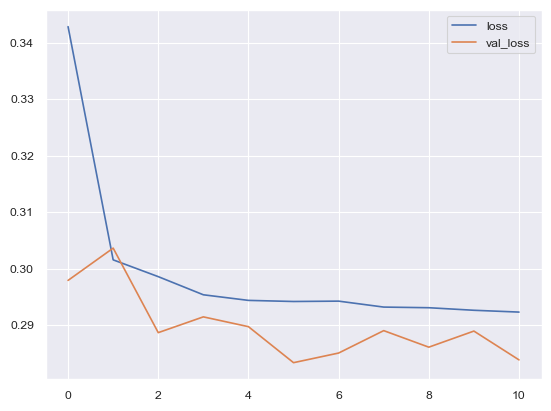

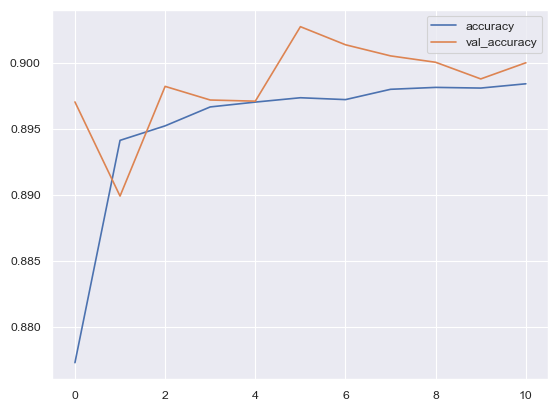

In [68]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

5325/5325 [==============================] - 8s 1ms/step
[[58309 13339]
 [ 3187 95553]]
Accuracy: 0.9030096016151372
Precision: 0.8775024795209933
Recall: 0.9677233137532915
F1 Score: 0.9204072589966865
AUC: 0.942404032109289


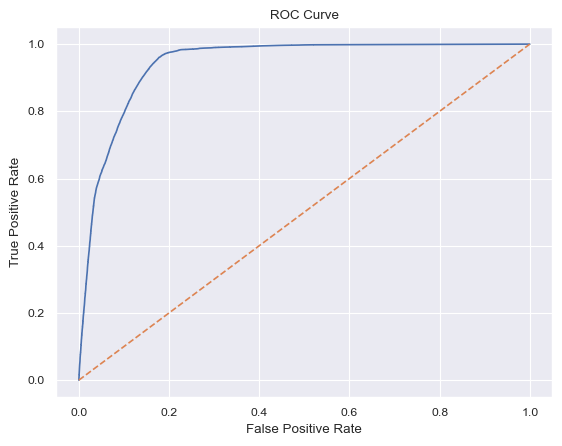

In [69]:
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5)
y_pred_proba = y_pred_proba.ravel()

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

from sklearn.metrics import roc_auc_score
print("AUC:", roc_auc_score(y_test, y_pred_proba))

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [70]:
results = pd.DataFrame({'label': y_test})
results["score"] = y_pred.astype(int)
results["applicant_sex"] = HMDA_clean_final.loc[results.index, "applicant_sex"]
results["applicant_race-1"] = HMDA_clean_final.loc[results.index, "applicant_race-1"]

results["label"] = results["label"].astype("int")
results["score"] = results["score"].astype("int")

results["applicant_sex"] = results["applicant_sex"].astype("object")
results["applicant_race-1"] = results["applicant_race-1"].astype("object")

In [71]:
print(results.head(), "\n", results.shape, "\n", results.dtypes)

        label  score applicant_sex           applicant_race-1
238575      1      1          Male                      White
328268      0      0          Male                      White
594872      1      1          Male                      White
635106      1      1          Male                      White
451212      0      0        Female  Black or African American 
 (170388, 4) 
 label                int32
score                int32
applicant_sex       object
applicant_race-1    object
dtype: object


In [72]:
import aequitas

audit = aequitas.Audit(results)

In [73]:
g = aequitas.group.Group()

results_ren = results.copy()
results_ren["label_value"] = results["label"]
results_ren.drop(columns="label", inplace=True)

xtab, _ = g.get_crosstabs(results_ren)

In [74]:
absolute_metrics = g.list_absolute_metrics(xtab)

xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,0,binary 0/1,108892,applicant_sex,Female,36465,22691,4683,1187,21504,31782,32969,26187,59156,170388
1,0,binary 0/1,108892,applicant_sex,Male,72427,38805,8656,2000,36805,63771,65771,45461,111232,170388
2,0,binary 0/1,108892,applicant_race-1,Black or African American,13377,13076,2199,818,12258,11178,11996,14457,26453,170388
3,0,binary 0/1,108892,applicant_race-1,White,95515,48420,11140,2369,46051,84375,86744,57191,143935,170388


In [75]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,applicant_sex,Female,0.90,0.96,0.82,0.05,0.13,0.18,0.04,0.95,0.87,0.33,0.62,0.56
1,applicant_sex,Male,0.90,0.97,0.81,0.05,0.12,0.19,0.03,0.95,0.88,0.67,0.65,0.59
2,applicant_race-1,Black or African American,0.89,0.93,0.85,0.06,0.16,0.15,0.07,0.94,0.84,0.12,0.51,0.45
3,applicant_race-1,White,0.91,0.97,0.81,0.05,0.12,0.19,0.03,0.95,0.88,0.88,0.66,0.60


In [76]:
aqp = aequitas.plotting.Plot()

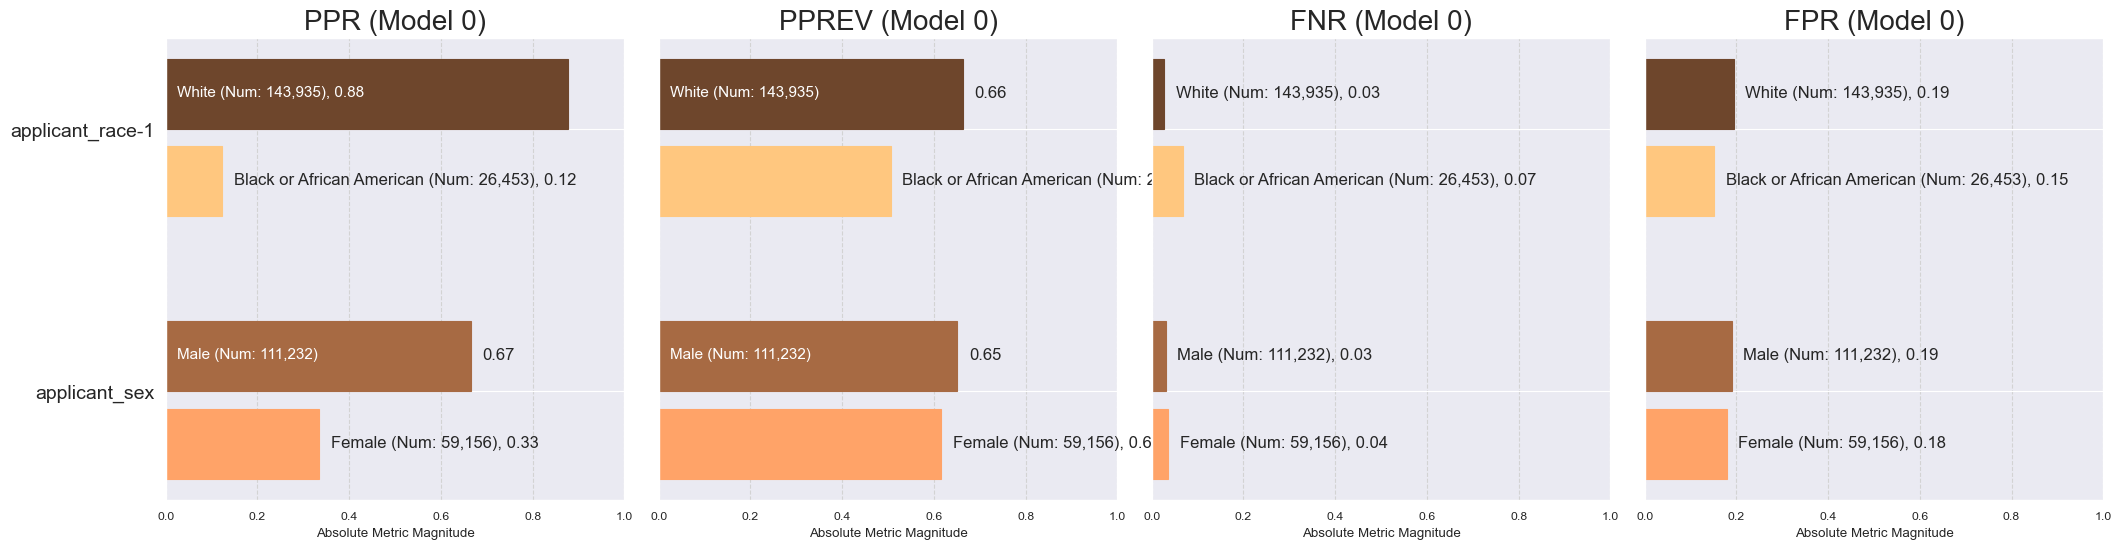

<Figure size 640x480 with 0 Axes>

In [77]:
group_metric_all = aqp.plot_group_metric_all(xtab, metrics=['ppr','pprev','fnr','fpr'], ncols=4)

In [78]:
b = aequitas.bias.Bias()

In [79]:
bdf = b.get_disparity_predefined_groups(xtab, original_df=results_ren, ref_groups_dict={'applicant_race-1':'White', 'applicant_sex':'Male'}, alpha=0.05, mask_significance=True)
bdf.style

,model_id,score_threshold,k,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity,ppr_ref_group_value,pprev_ref_group_value,precision_ref_group_value,fdr_ref_group_value,for_ref_group_value,fpr_ref_group_value,fnr_ref_group_value,tpr_ref_group_value,tnr_ref_group_value,npv_ref_group_value
0,0,binary 0/1,108892,applicant_sex,Female,0.900771,0.963996,0.821171,0.052311,0.128425,0.178829,0.036004,0.947689,0.871575,36465,22691,0.334873,0.616421,4683,1187,21504,31782,32969,26187,59156,170388,0.557323,0.503472,0.946688,0.989879,1.074561,1.014974,0.939204,1.183994,0.994230,1.014298,0.999186,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male
1,0,binary 0/1,108892,applicant_sex,Male,0.904200,0.969591,0.809595,0.051540,0.119513,0.190405,0.030409,0.948460,0.880487,72427,38805,0.665127,0.651135,8656,2000,36805,63771,65771,45461,111232,170388,0.591296,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male
2,0,binary 0/1,108892,applicant_race-1,Black or African American,0.885949,0.931811,0.847894,0.062557,0.164387,0.152106,0.068189,0.937443,0.835613,13377,13076,0.122846,0.505689,2199,818,12258,11178,11996,14457,26453,170388,0.453484,0.140051,0.762042,0.945939,1.409460,1.278610,0.780889,2.496843,0.957973,1.053004,0.985667,White,White,White,White,White,White,White,White,White,White
3,0,binary 0/1,108892,applicant_race-1,White,0.906145,0.972690,0.805214,0.048926,0.116631,0.194786,0.027310,0.951074,0.883369,95515,48420,0.877154,0.663598,11140,2369,46051,84375,86744,57191,143935,170388,0.602661,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,White,White,White,White,White,White,White,White,White,White


In [80]:
calculated_disparities = b.list_disparities(bdf)
disparity_significance = b.list_significance(bdf)

In [81]:
disparity_significance

[]